In [83]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import FileLink
from scipy.optimize import curve_fit

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import helpers

%matplotlib inline

## Importing processed data

In [16]:
# df = pd.read_csv('../data/processed/laps.csv', index_col=["Id", "Intervalle"])
df = pd.read_csv('../data/processed/laps.csv')
df["Id"] = df["Id"].astype(str)
df.set_index(["Id","Intervalle"], inplace=True)
df["avg_hr"] = df["avg_hr"].fillna(value=df["avg_hr"].mean()).astype(int)
df["max_hr"] = df["max_hr"].fillna(value=df["max_hr"].mean()).astype(int)

print("Dataframe successfully created.\nLink to the CSV file:")
FileLink('../data/processed/laps.csv')

Dataframe successfully created.
Link to the CSV file:


C:\Users\robin\Documents\GitHub\running-panda\data\processed\laps.csv

## Droping buggy or non-running data points

In [25]:
# General Rules
speed_bugs = (df["pace"]<10)&(df["pace"]>2.38) # >7min/km
pace_bugs = df["pace"]<df["best_pace"]
interludes = df["time"]>7
resting = (df["distance"]>0.1) | (df["pace"]>4.7) # >3min30/km

criteria = speed_bugs & interludes & pace_bugs & resting
df = df[criteria]
# df = df[(df["pace"]<10)&(df["pace"]>1)]
# df = df[df["time"]>7]
# df = df[df["pace"]<df["best_pace"]]
len(df)


# Manual inspection
# df.drop("1275130625", axis=0, level="Id", inplace=True)
# Subset by labels for Multi-index df
# print(df.loc[("2136561739", "1"),:]["distance"])

2273

## DF1 Consists of the totals/summaries

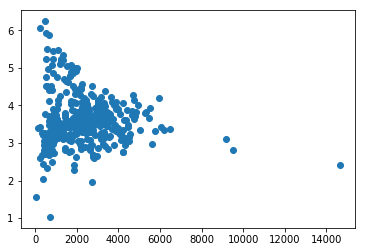

In [4]:
max_lap = df.index.levels[1].tolist()
max_lap.remove('Summary')
df1 = df.drop(max_lap, level="Intervalle")
plt.scatter(df1["time"], df1["pace"])

## DF2 Consists of all the laps (more granularity)

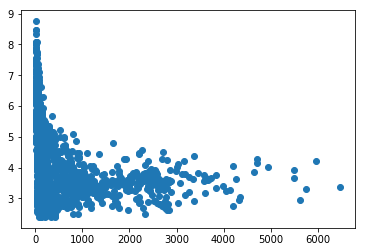

In [26]:
df2 = df.drop(["Summary"], level="Intervalle")
plt.scatter(df2["time"], df2["pace"])

## Lap data - Correlation between variables

In [6]:
df2.corr()

,distance,time,pace,best_pace,d_plus,d_minus,cadence,stride_length,avg_hr,max_hr,kcal
distance,1.000000,0.988496,-0.135097,-0.022046,0.872571,0.876807,0.122077,-0.091248,-0.065812,0.159112,0.977950
time,0.988496,1.000000,-0.195151,-0.039775,0.872131,0.871664,0.087463,-0.131981,-0.098504,0.138593,0.969701
pace,-0.135097,-0.195151,1.000000,0.347041,-0.168012,-0.156545,0.534750,0.715649,0.163127,0.044205,-0.177884
best_pace,-0.022046,-0.039775,0.347041,1.000000,-0.053047,-0.048601,0.027165,0.281628,0.038685,0.086268,-0.035542
d_plus,0.872571,0.872131,-0.168012,-0.053047,1.000000,0.928832,0.066850,-0.115992,-0.039908,0.140295,0.868106
d_minus,0.876807,0.871664,-0.156545,-0.048601,0.928832,1.000000,0.075944,-0.107743,-0.046864,0.137611,0.868571
cadence,0.122077,0.087463,0.534750,0.027165,0.066850,0.075944,1.000000,0.184820,0.160848,0.047955,0.081226
stride_length,-0.091248,-0.131981,0.715649,0.281628,-0.115992,-0.107743,0.184820,1.000000,0.097965,0.026138,-0.117477
avg_hr,-0.065812,-0.098504,0.163127,0.038685,-0.039908,-0.046864,0.160848,0.097965,1.000000,0.832286,-0.001319
max_hr,0.159112,0.138593,0.044205,0.086268,0.140295,0.137611,0.047955,0.026138,0.832286,1.000000,0.210081


## Lap Data - minutes in each heartzone

<Container object of 6 artists>

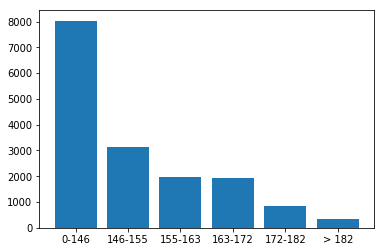

In [6]:
df2["zone"] = df2.apply(helpers.classify_zone, axis=1)
s= df2.groupby("zone")["time"].sum()/60
plt.bar(["0-146","146-155","155-163","163-172","172-182","> 182"], s.tolist())

## Playing around non-linear regression

-0.485657395747 7.17511399246


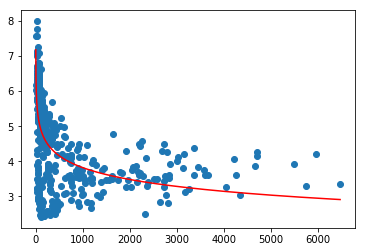

In [129]:
pd.options.mode.chained_assignment = None
df3 = df2[df2["max_hr"]>180]

a, b = np.polyfit(np.log(df3["time"]), df3["pace"], 1)
print(a,b)

# p = scipy.optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  df3["minute"],  df3["pace"])
# c,d = p[0][0], p[0][1]
# print(c,d)

def func(x,a,b):
    return a * np.log(x) + b

x = math.ceil(df3["time"].max())
plt.scatter(df3["time"], df3["pace"])
plt.plot(range(1, x), func(range(1, x), a, b), 'r-')

## Compairing with JD's FVO2max

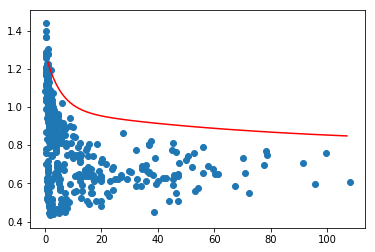

In [132]:
df3["minute"] = df3["time"]/60
df3["f_vo2"] = df3["pace"]/5.555

def jd(x):
    x = pd.Series.from_array(x)
    return 0.8 + 0.298956 * np.exp(-0.193261 * x) + 0.189438 * np.exp(-0.012778 * x)

x = math.ceil(df3["minute"].max())
plt.scatter(df3["minute"], df3["f_vo2"])
plt.plot(range(1, x), jd(range(1, x)), 'r-')